# Partial Correlation

The purpose of this notebook is to understand how to compute the [partial correlation](https://en.wikipedia.org/wiki/Partial_correlation) between two variables, $X$ and $Y$, given a third $Z$. In particular, these variables are assumed to be guassians (or, in general, multivariate gaussians). 

Why is it important to estimate partial correlations? The primary reason for estimating a partial correlation is to use it to detect for [confounding](https://en.wikipedia.org/wiki/Confounding_variable) variables during causal analysis. 

## Simulation

Let's start out by simulating 3 data sets. Graphically, these data sets comes from graphs represented by the following.

* $X \rightarrow Z \rightarrow Y$ (serial)
* $X \leftarrow Z \rightarrow Y$ (diverging)
* $X \rightarrow Z \leftarrow Y$ (converging)

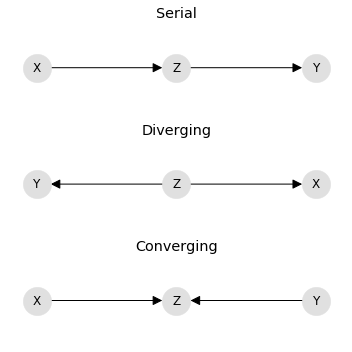

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

def get_serial_graph():
    g = nx.DiGraph()
    
    g.add_node('X')
    g.add_node('Y')
    g.add_node('Z')
    
    g.add_edge('X', 'Z')
    g.add_edge('Z', 'Y')
    
    return g

def get_diverging_graph():
    g = nx.DiGraph()
    
    g.add_node('X')
    g.add_node('Y')
    g.add_node('Z')
    
    g.add_edge('Z', 'X')
    g.add_edge('Z', 'Y')
    
    return g

def get_converging_graph():
    g = nx.DiGraph()
    
    g.add_node('X')
    g.add_node('Y')
    g.add_node('Z')
    
    g.add_edge('X', 'Z')
    g.add_edge('Y', 'Z')
    
    return g

g_serial = get_serial_graph()
g_diverging = get_diverging_graph()
g_converging = get_converging_graph()

p_serial = nx.nx_agraph.graphviz_layout(g_serial, prog='dot', args='-Kcirco')
p_diverging = nx.nx_agraph.graphviz_layout(g_diverging, prog='dot', args='-Kcirco')
p_converging = nx.nx_agraph.graphviz_layout(g_converging, prog='dot', args='-Kcirco')

fig, ax = plt.subplots(3, 1, figsize=(5, 5))

nx.draw(g_serial, pos=p_serial, with_labels=True, node_color='#e0e0e0', node_size=800, arrowsize=20, ax=ax[0])
nx.draw(g_diverging, pos=p_diverging, with_labels=True, node_color='#e0e0e0', node_size=800, arrowsize=20, ax=ax[1])
nx.draw(g_converging, pos=p_converging, with_labels=True, node_color='#e0e0e0', node_size=800, arrowsize=20, ax=ax[2])

ax[0].set_title('Serial')
ax[1].set_title('Diverging')
ax[2].set_title('Converging')

plt.tight_layout()

In the serial graph, `X` causes `Z` and `Z` causes `Y`. In the diverging graph, `Z` causes both `X` and `Y`. In the converging graph, `X` and `Y` cause `Z`. Below, the serial, diverging, and converging data sets are named S, D, and C, correspondingly.

Note that in the serial graph, the data is sampled as follows.

* $X \sim \mathcal{N}(0, 1)$
* $Z \sim 2 + 1.8 \times X$
* $Y \sim 5 + 2.7 \times Z$

In the diverging graph, the data is sampled as follows.

* $Z \sim \mathcal{N}(0, 1)$
* $X \sim 4.3 + 3.3 \times Z$
* $Y \sim 5.0 + 2.7 \times Z$

Lastly, in the converging graph, the data is sampled as follows.

* $X \sim \mathcal{N}(0, 1)$
* $Y \sim \mathcal{N}(5.5, 1)$
* $Z \sim 2.0 + 0.8 \times X + 1.2 \times Y$

Note the ordering of the sampling with the variables follows the structure of the corresponding graph.

In [2]:
import numpy as np

np.random.seed(37)

def get_error(N=10000, mu=0.0, std=0.2):
    return np.random.normal(mu, std, N)

def to_matrix(X, Z, Y):
    return np.concatenate([
        X.reshape(-1, 1), 
        Z.reshape(-1, 1), 
        Y.reshape(-1, 1)], axis=1)

def get_serial(N=10000, e_mu=0.0, e_std=0.2):
    X = np.random.normal(0, 1, N) + get_error(N, e_mu, e_std)
    Z = 2 + 1.8 * X + get_error(N, e_mu, e_std)
    Y = 5 + 2.7 * Z + get_error(N, e_mu, e_std)

    return to_matrix(X, Z, Y)

def get_diverging(N=10000, e_mu=0.0, e_std=0.2):
    Z = np.random.normal(0, 1, N) + get_error(N, e_mu, e_std)
    X = 4.3 + 3.3 * Z + get_error(N, e_mu, e_std)
    Y = 5 + 2.7 * Z + get_error(N, e_mu, e_std)

    return to_matrix(X, Z, Y)

def get_converging(N=10000, e_mu=0.0, e_std=0.2):
    X = np.random.normal(0, 1, N) + get_error(N, e_mu, e_std)
    Y = np.random.normal(5.5, 1, N) + get_error(N, e_mu, e_std)
    Z = 2 + 0.8 * X + 1.2 * Y + get_error(N, e_mu, e_std)
    
    return to_matrix(X, Z, Y)

In [3]:
S = get_serial()
D = get_diverging()
C = get_converging()

## Computation

For the three datasets, `S`, `D`, and `C`, we want to compute the partial correlation between $X$ and $Y$ given $Z$. The way to do this is as follows.

* Regress $X$ on $Z$ and also $Y$ on $Z$
  * $X = b_X + w_X * Z$
  * $Y = b_Y + w_Y * Z$
* With the new weights $(b_X, w_X)$ and $(b_Y, w_Y)$, predict $X$ and $Y$.
  * $\hat{X} = b_X + w_X * Z$
  * $\hat{Y} = b_Y + w_Y * Z$
* Now compute the residuals between the true and predicted values.
  * $R_X = X - \hat{X}$
  * $R_Y = Y - \hat{Y}$
* Finally, compute the Pearson correlation between $R_X$ and $R_Y$.

The correlation between the residuals is the partial correlation and runs from -1 to +1. More interesting is the test of significance. If $p > \alpha$, where $\alpha \in [0.1, 0.05, 0.01]$, then assume independence. For example, assume $\alpha = 0.01$ and $p = 0.002$, then $X$ is conditionally independent of $Y$ given $Z$.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy import stats

def get_cond_indep_test(c_xy_z, N=10000, alpha=0.01):
    point = stats.norm.ppf(1 - (alpha / 2.0))
    z_transform = np.sqrt(N - 3) * np.abs(0.5 * np.log((1 + c_xy_z) / (1 - c_xy_z)))
    return z_transform, point, z_transform > point

def get_partial_corr(M):
    X = M[:, 0]
    Z = M[:, 1].reshape(-1, 1)
    Y = M[:, 2]

    mXZ = LinearRegression()
    mXZ.fit(Z, X)
    pXZ = mXZ.predict(Z)
    rXZ = X - pXZ

    mYZ = LinearRegression()
    mYZ.fit(Z, Y)
    pYZ = mYZ.predict(Z)
    rYZ = Y - pYZ

    c_xy, p_xy = pearsonr(X, Y)
    c_xy_z, p_xy_z = pearsonr(rXZ, rYZ)

    return c_xy, p_xy, c_xy_z, p_xy_z

## Serial graph data

For $X \rightarrow Z \rightarrow Y$, note that the marginal correlation is high (0.99) and the correlation is significant (p < 0.01). However, the correlation between X and Y vanishes given Z to -0.01 (p > 0.01). Note the conditional independence test fails to reject the null hypothesis.

In [5]:
c_xy, p_xy, c_xy_z, p_xy_z = get_partial_corr(S)
print(f'corr_xy={c_xy:.5f}, p_xy={p_xy:.5f}')
print(f'corr_xy_z={c_xy_z:.5f}, p_xy_z={p_xy_z:.5f}')
print(get_cond_indep_test(c_xy_z))

corr_xy=0.99331, p_xy=0.00000
corr_xy_z=-0.01493, p_xy_z=0.13543
(1.4930316470699307, 2.5758293035489004, False)


## Diverging graph data

For $X \leftarrow Z \rightarrow Y$, note that the marginal correlation is high (0.99) and the correlation is significant (p < 0.01). However, the correlation between X and Y vanishes given Z to 0.01 (p > 0.01). Note the conditional independence test fails to reject the null hypothesis.

In [6]:
c_xy, p_xy, c_xy_z, p_xy_z = get_partial_corr(D)
print(f'corr_xy={c_xy:.5f}, p_xy={p_xy:.5f}')
print(f'corr_xy_z={c_xy_z:.5f}, p_xy_z={p_xy_z:.5f}')
print(get_cond_indep_test(c_xy_z))

corr_xy=0.99575, p_xy=0.00000
corr_xy_z=0.01155, p_xy_z=0.24815
(1.1548311182263977, 2.5758293035489004, False)


## Converging graph data

For $X \rightarrow Z \leftarrow Y$, note that the correlation is low (-0.00) and the correlation is insignficiant (p > 0.01). However, the correlation between X and Y increases to -0.96  and becomes significant (p < 0.01)! Note the conditional independence test rejects the null hypothesis.

In [7]:
c_xy, p_xy, c_xy_z, p_xy_z = get_partial_corr(C)
print(f'corr_xy={c_xy:.5f}, p_xy={p_xy:.5f}')
print(f'corr_xy_z={c_xy_z:.5f}, p_xy_z={p_xy_z:.5f}')
print(get_cond_indep_test(c_xy_z))

corr_xy=-0.00269, p_xy=0.78774
corr_xy_z=-0.95791, p_xy_z=0.00000
(191.9601051372688, 2.5758293035489004, True)


## Statistically Distinguishable

The `serial` and `diverging` graphs are said to be `statistically indistingishable` since $X$ and $Y$ are both `conditionally independent` given $Z$. However, the `converging` graph is `statistically distinguishable` since it is the only graph where $X$ and $Y$ are `conditionally dependent` given $Z$.